In [67]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn

from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import wfdb

from tqdm import tqdm
# import torchviz

In [80]:
x =  np.load(r"dataset\Chip\train_500\X_long.npy")
y = np.load(r"dataset\Chip\train_500\y_long.npy")


x_val = np.load(r"dataset\Chip\validation\X_long.npy")
y_val = np.load(r"dataset\Chip\validation\y_long.npy")

x_test = np.load(r"dataset\Chip\test\X_long.npy")
y_test = np.load(r"dataset\Chip\test\y_long.npy")

x = x[:, 8:9, 200:800]
x_val = x_val[:, 8:9, 200:800]
x_test = x_test[:, 8:9, 200:800]

print(f'X shape: {x.shape} y shape: {y.shape}')
print(f'X_val shape: {x_val.shape} y_val shape: {y_val.shape}')
print(f'X_test shape: {x_test.shape} y_test shape: {y_test.shape}')



X shape: (6000, 1, 600) y shape: (6000,)
X_val shape: (600, 1, 600) y_val shape: (600,)
X_test shape: (600, 1, 600) y_test shape: (600,)


Unique trials in x: 161
Unique trials in x_val: 27
Unique trials in x_test: 7


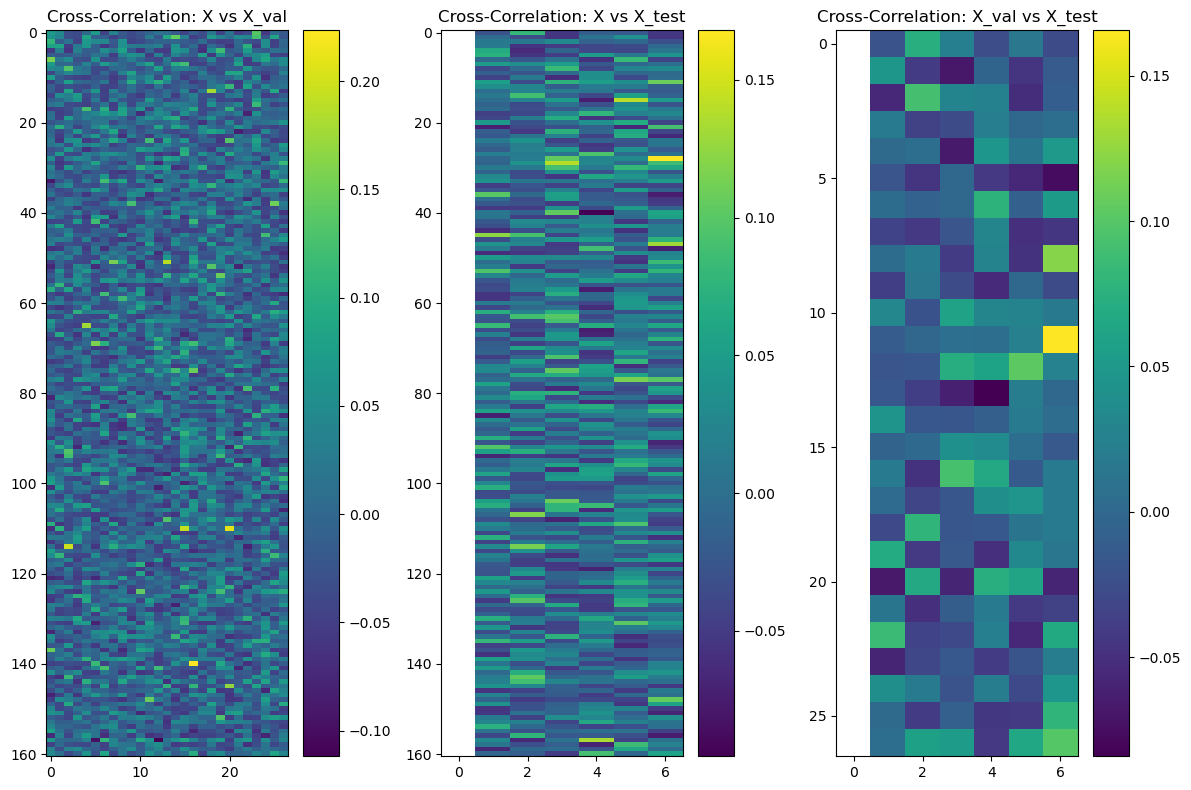

Plotting top correlated pairs between X and X_val...


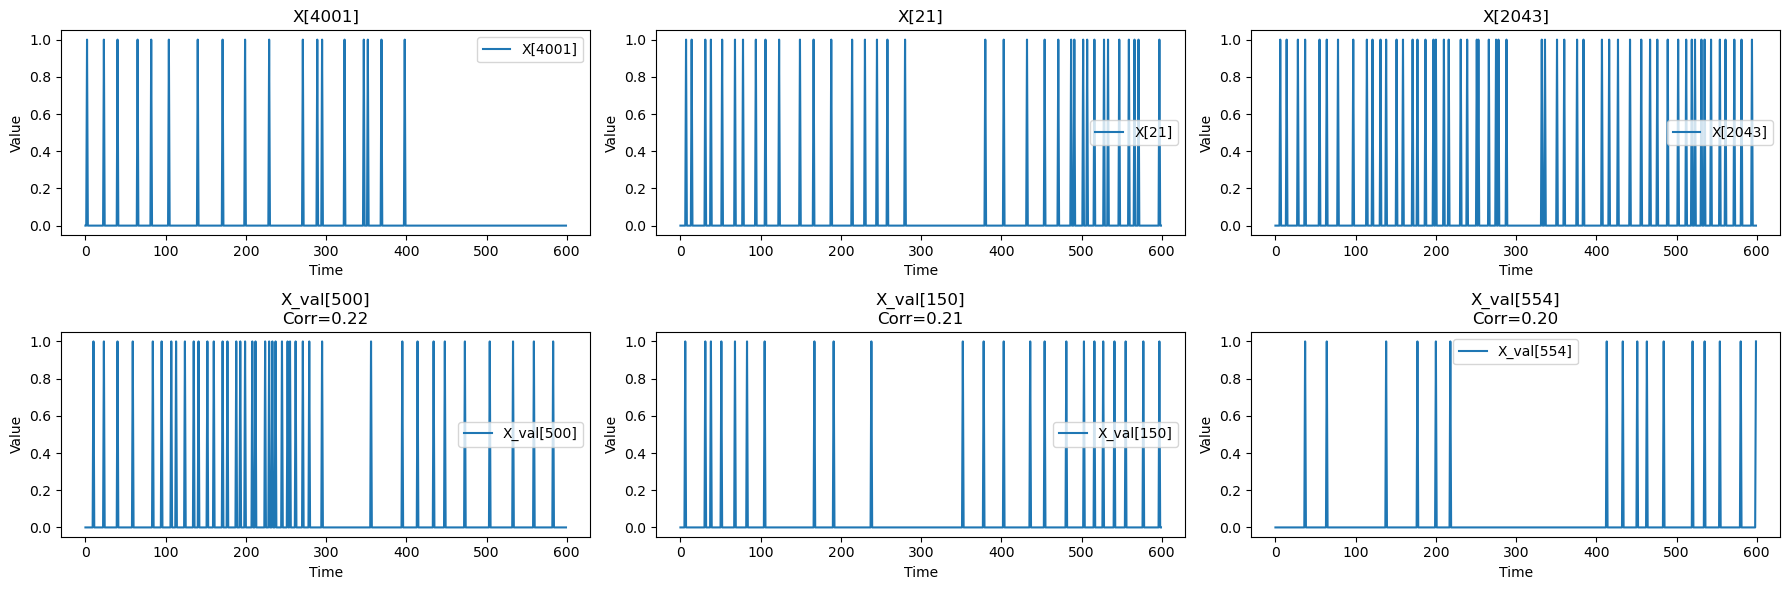

Plotting top correlated pairs between X and X_test...


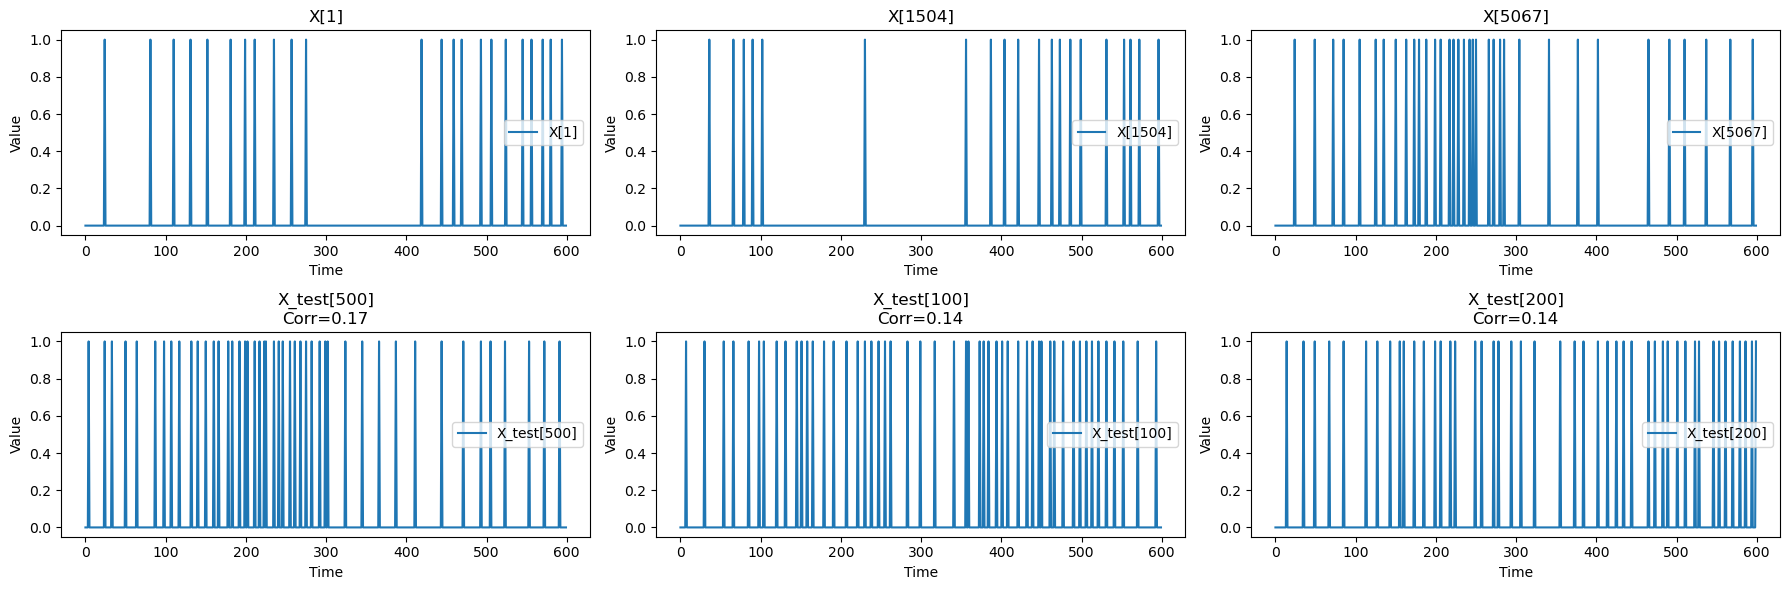

Plotting top correlated pairs between X_val and X_test...


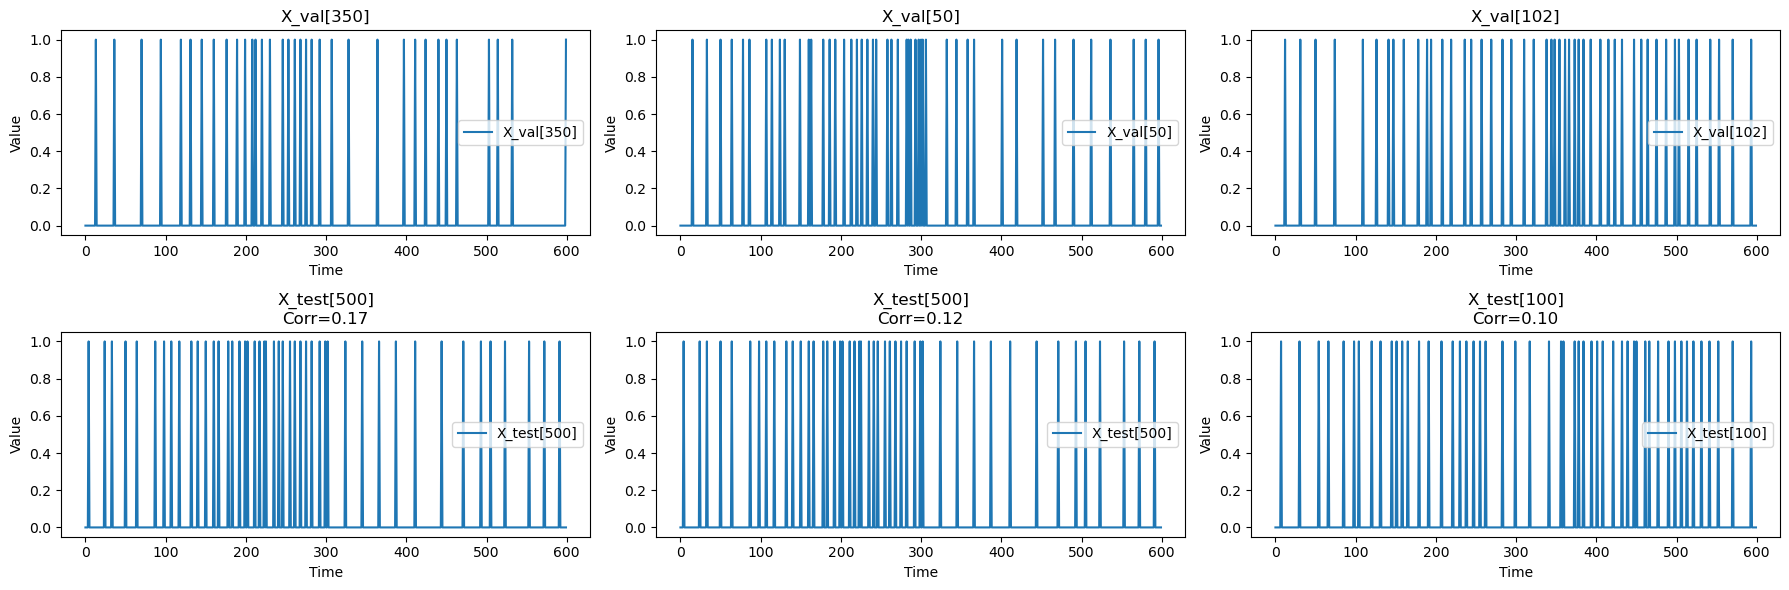

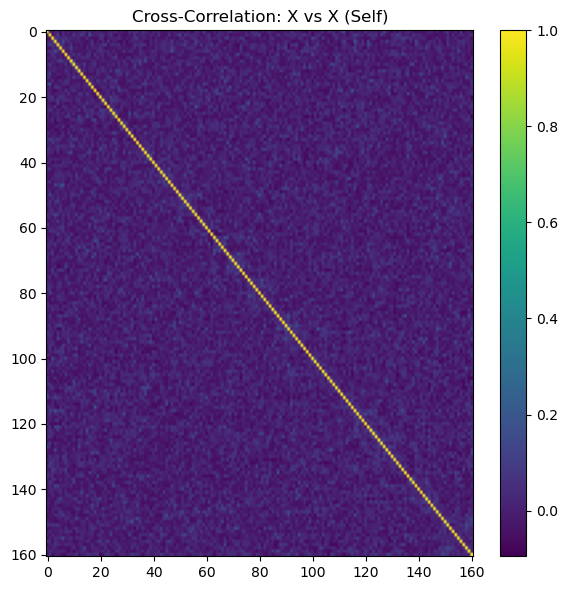

In [81]:
### CHECK DATA LEAKAGE

%matplotlib inline
# find how many unique values there are in x , x_val , x_test - run cross correlation on them and see if there is any similarity between them
# Find unique elements along the first axis (i.e., unique trials)
# Each element is of shape (1, 600)
x_uniq, x_idx = np.unique(x, axis=0, return_index=True)
x_val_uniq, x_val_idx = np.unique(x_val, axis=0, return_index=True)
x_test_uniq, x_test_idx = np.unique(x_test, axis=0, return_index=True)

print(f'Unique trials in x: {x_uniq.shape[0]}')
print(f'Unique trials in x_val: {x_val_uniq.shape[0]}')
print(f'Unique trials in x_test: {x_test_uniq.shape[0]}')

# Cross-correlation between the first 10 unique trials of each set
def cross_corr_matrix(a, b):
    # a: [N, C, T], b: [M, C, T]
    n, c, t = a.shape
    m = b.shape[0]
    corr = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            # Flatten and normalize
            a_flat = a[i].flatten()
            b_flat = b[j].flatten()
            if np.std(a_flat) > 0 and np.std(b_flat) > 0:
                corr[i, j] = np.corrcoef(a_flat, b_flat)[0, 1]
            else:
                corr[i, j] = np.nan
    return corr

corr_x_val = cross_corr_matrix(x_uniq, x_val_uniq)
corr_x_test = cross_corr_matrix(x_uniq, x_test_uniq)
corr_val_test = cross_corr_matrix(x_val_uniq, x_test_uniq)

# Plotting the cross-correlation matrices
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(corr_x_val, cmap='viridis', aspect='auto')
plt.title('Cross-Correlation: X vs X_val')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(corr_x_test, cmap='viridis', aspect='auto')
plt.title('Cross-Correlation: X vs X_test')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(corr_val_test, cmap='viridis', aspect='auto')
plt.title('Cross-Correlation: X_val vs X_test')
plt.colorbar()
plt.tight_layout()
plt.savefig('cross_correlation_matrices.png')
plt.show()


# show side by side the 3 highest cross-correlated trials from each two sets
# Show side by side the 3 highest cross-correlated trials from each two sets
def plot_top_correlated_pairs_timeseries(corr_matrix, set_a, set_b, idx_a, idx_b, set_a_name, set_b_name, top_n=3):
    # Find the top N pairs with highest correlation (excluding NaNs)
    # Mask out NaN values before selecting top correlations
    flat_corr = corr_matrix.flatten()
    valid_mask = ~np.isnan(flat_corr)
    valid_corr = flat_corr[valid_mask]
    if len(valid_corr) < top_n:
        top_n = len(valid_corr)
    top_indices_valid = np.argpartition(valid_corr, -top_n)[-top_n:]
    top_indices_valid = top_indices_valid[np.argsort(valid_corr[top_indices_valid])[::-1]]  # sort descending
    # Map back to original indices
    valid_flat_indices = np.where(valid_mask)[0][top_indices_valid]
    pairs = [np.unravel_index(i, corr_matrix.shape) for i in valid_flat_indices]

    plt.figure(figsize=(top_n * 6, 6))
    for k, (i, j) in enumerate(pairs):
        # Plot set_a time series
        plt.subplot(2, top_n, k + 1)
        # Squeeze to 1D if needed
        a_ts = set_a[i].squeeze()
        if a_ts.ndim > 1:
            a_ts = a_ts.flatten()
        plt.plot(a_ts, label=f'{set_a_name}[{idx_a[i]}]')
        plt.title(f'{set_a_name}[{idx_a[i]}]')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        # Plot set_b time series
        plt.subplot(2, top_n, k + 1 + top_n)
        b_ts = set_b[j].squeeze()
        if b_ts.ndim > 1:
            b_ts = b_ts.flatten()
        plt.plot(b_ts, label=f'{set_b_name}[{idx_b[j]}]')
        plt.title(f'{set_b_name}[{idx_b[j]}]\nCorr={corr_matrix[i, j]:.2f}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
    plt.tight_layout()
    plt.show()

print("Plotting top correlated pairs between X and X_val...")
# X vs X_val
plot_top_correlated_pairs_timeseries(
    corr_x_val, x_uniq, x_val_uniq, x_idx, x_val_idx, 'X', 'X_val', top_n=3
)

print("Plotting top correlated pairs between X and X_test...")
# X vs X_test
plot_top_correlated_pairs_timeseries(
    corr_x_test, x_uniq, x_test_uniq, x_idx, x_test_idx, 'X', 'X_test', top_n=3
)

print("Plotting top correlated pairs between X_val and X_test...")
# X_val vs X_test
plot_top_correlated_pairs_timeseries(
    corr_val_test, x_val_uniq, x_test_uniq, x_val_idx, x_test_idx, 'X_val', 'X_test', top_n=3
)

#for sanity check - try croos-correlation between a dataset and itself
sanity = cross_corr_matrix(x_uniq, x_uniq)
plt.figure(figsize=(6, 6))
plt.imshow(sanity, cmap='viridis', aspect='auto')
plt.title('Cross-Correlation: X vs X (Self)')
plt.colorbar()
plt.tight_layout()
plt.savefig('cross_correlation_self.png')
plt.show()


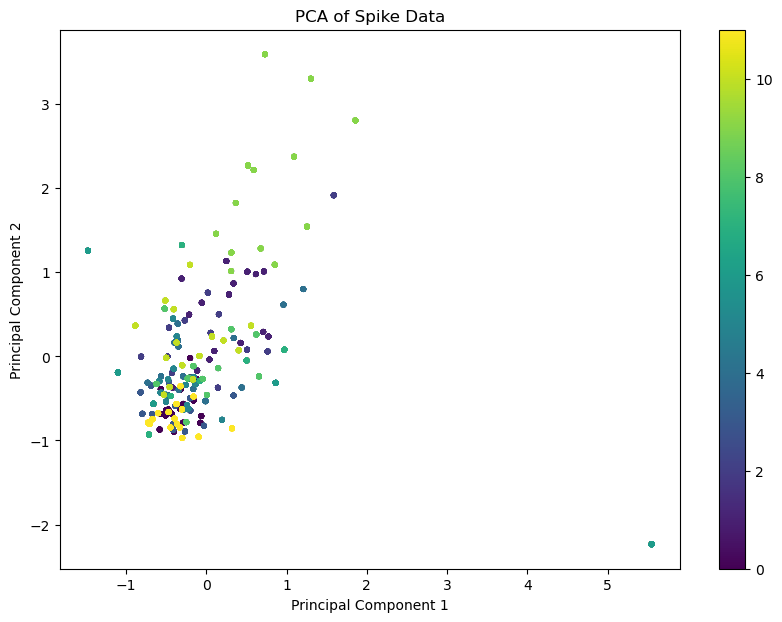

Validation Accuracy: 0.2333
Test Accuracy: 0.3750
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.32      1.00      0.48        50
           1       0.00      0.00      0.00        50
           2       1.00      0.10      0.18        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50
           5       0.00      0.00      0.00        50
           6       0.00      0.00      0.00        50
           7       0.00      0.00      0.00        50
           8       0.24      0.40      0.30        50
           9       1.00      0.58      0.73        50
          10       0.44      0.24      0.31        50
          11       0.19      0.48      0.27        50

    accuracy                           0.23       600
   macro avg       0.27      0.23      0.19       600
weighted avg       0.27      0.23      0.19       600

Test Classification Report:
              precisi

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packag

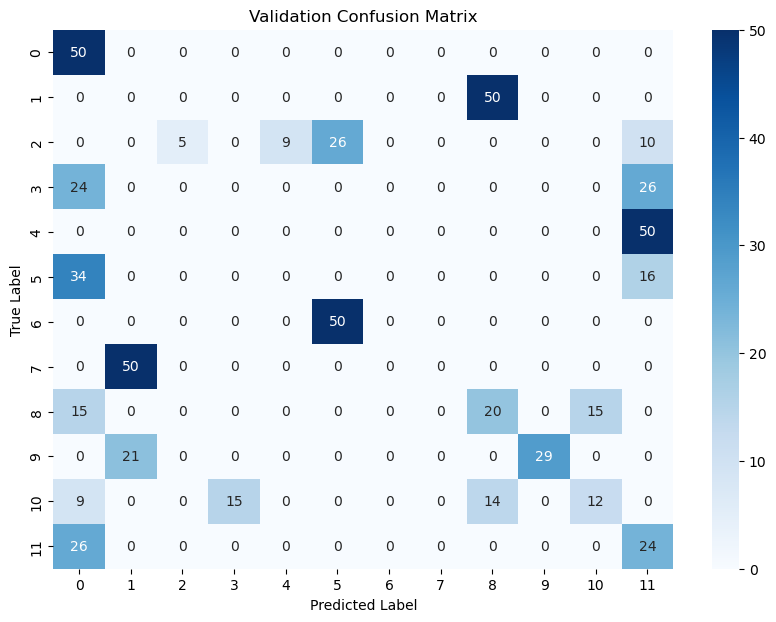

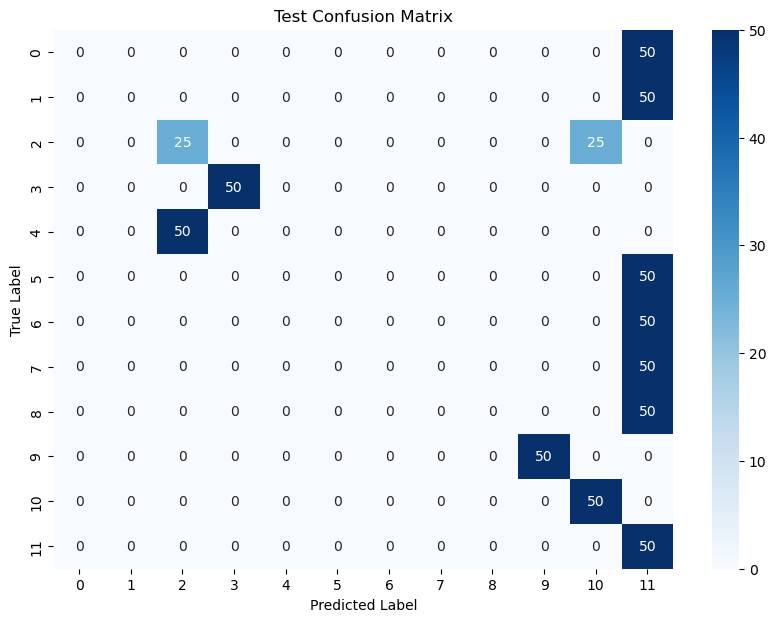

Training Cross-Entropy Loss: 0.0066
Validation Cross-Entropy Loss: 2.1825
Test Cross-Entropy Loss: 2.1331


In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Flatten x_val for logistic regression: [samples, neurons, time] -> [samples, neurons*time]
X_flat = x.reshape(x.shape[0], -1)
X_flat_val = x_val.reshape(x_val.shape[0], -1)
X_flat_test = x_test.reshape(x_test.shape[0], -1)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

# Plot PCA
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=10)
plt.title('PCA of Spike Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

# Train a logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_flat, y)
# Make predictions on the validation set
y_pred_val = log_reg.predict(X_flat_val)
# Make predictions on the test set
y_pred_test = log_reg.predict(X_flat_test)

# Calculate accuracy
accuracy_val = accuracy_score(y_val, y_pred_val)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Validation Accuracy: {accuracy_val:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')

# Print confusion matrix
print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val))
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))

# Plot confusion matrix 
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
cm_val = confusion_matrix(y_val, y_pred_val)
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# calculate loss with croos entropy
loss_function = nn.CrossEntropyLoss()
# Calculate cross-entropy loss for validation and test sets

# Convert predictions and true labels to tensors
y_train_tensor = torch.tensor(y, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
# For cross-entropy, need logits (not probabilities), so use decision_function or predict_proba
train_logits = torch.tensor(log_reg.decision_function(X_flat), dtype=torch.float32)
val_logits = torch.tensor(log_reg.decision_function(X_flat_val), dtype=torch.float32)
test_logits = torch.tensor(log_reg.decision_function(X_flat_test), dtype=torch.float32)

train_loss = loss_function(train_logits, y_train_tensor).item()
val_loss = loss_function(val_logits, y_val_tensor).item()
test_loss = loss_function(test_logits, y_test_tensor).item()
print(f'Training Cross-Entropy Loss: {train_loss:.4f}')
print(f'Validation Cross-Entropy Loss: {val_loss:.4f}')
print(f'Test Cross-Entropy Loss: {test_loss:.4f}')



10


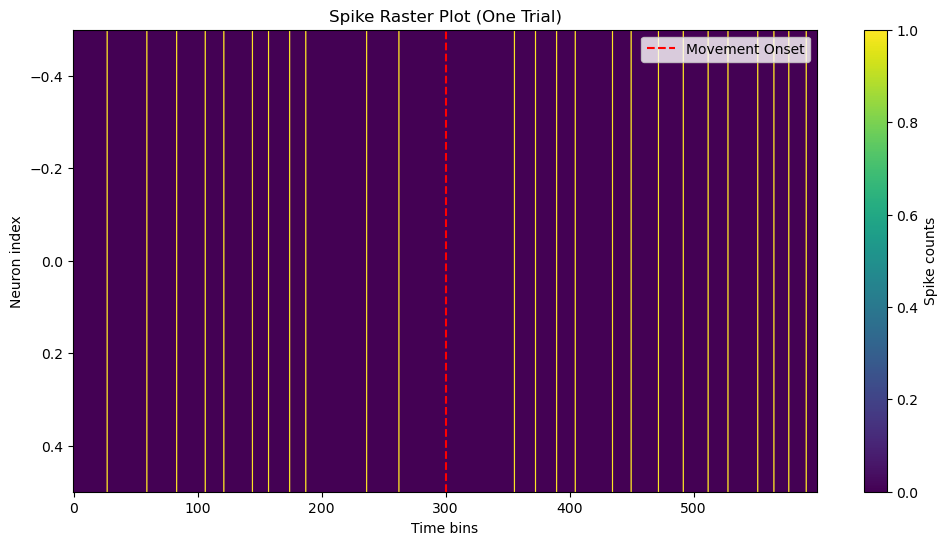

In [ ]:
# plot first trail for all neurons
i = 500

plt.figure(figsize=(12, 6))
print(y_test[i])
plt.imshow(x[i], aspect='auto', cmap='viridis')
plt.colorbar(label='Spike counts')
plt.axvline(x=300, color='red', linestyle='--', label='Movement Onset')
plt.legend()
plt.xlabel('Time bins')
plt.ylabel('Neuron index')
plt.title('Spike Raster Plot (One Trial)')
plt.show()

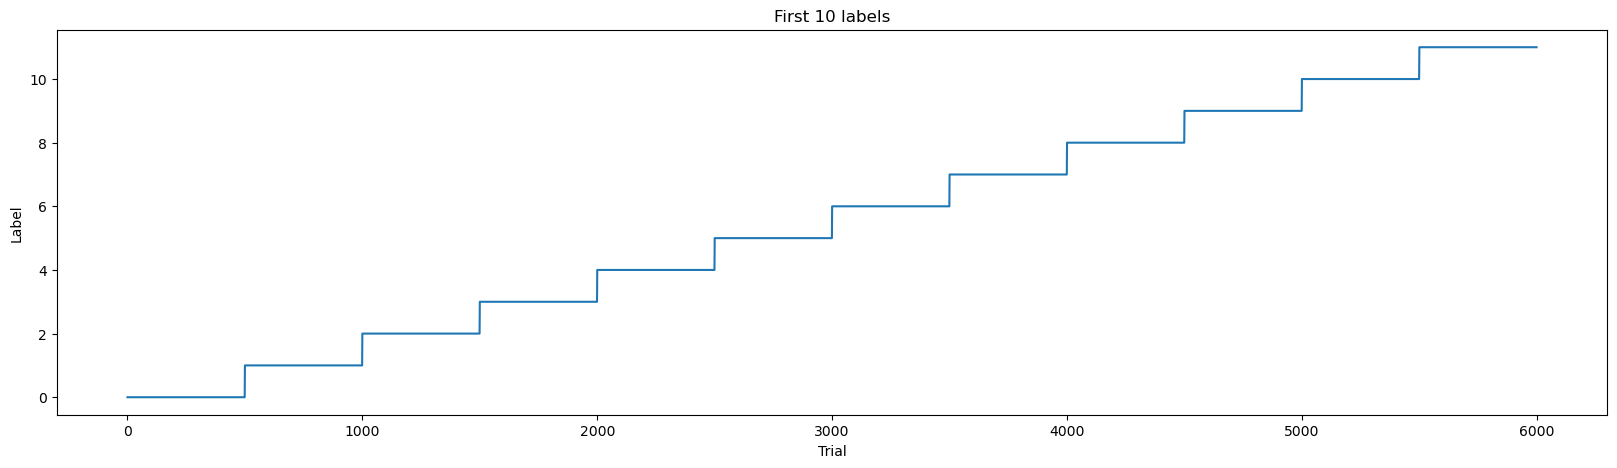

Labels: 0=1e , 1=1f , 2=2e , 3=2f , 4=3e , 5=3f , 6=4e , 7=4f ,  8=5e , 9=5f , 10=6e , 11=6f


In [13]:
# plot the labels
plt.figure(figsize=(20, 5))
plt.plot(y[:])
plt.title('First 10 labels')
plt.xlabel('Trial')
plt.ylabel('Label')
plt.show()
print('Labels: 0=1e , 1=1f , 2=2e , 3=2f , 4=3e , 5=3f , 6=4e , 7=4f ,  8=5e , 9=5f , 10=6e , 11=6f')

In [14]:
# transform the signal into a PyTorch tensor
class Ntransform(object):
    """
    This will transform the ECG signal into a PyTorch tensor. This is the place to apply other transformations as well, e.g., normalization, etc.
    """
    def __call__(self, signal):
        # Transform the data type from double (float64) to single (float32) to match the later network weights.
        t_signal = torch.from_numpy(signal).float()
        # We transpose the signal to later use the lead dim as the channel... (C,L).
        t_signal = t_signal.permute(1, 0)
        return t_signal  # Make sure I am a PyTorch Tensor

In [15]:
# Create a custom dataset class
class NeuronalDataset(Dataset):
    def __init__(self, signals_array, labels_array, transform=None):
        """
        Args:
            signals_array: np.ndarray, shape (N, T, C) -- neuronal activity
            labels_array: np.ndarray, shape (N,)        -- labels for samples
            transform: optional callable to transform signals
        """
        super().__init__()
        self.signals = signals_array
        self.labels = labels_array
        self.transform = transform

    def __getitem__(self, index):
        signal = self.signals[index]
        label = self.labels[index]

        if self.transform:
            signal = self.transform(signal)

        signal = signal.detach().clone().float()
        label = torch.tensor(label, dtype=torch.long)  #classification

        return signal, label

    def __len__(self):
        return len(self.signals)

In [83]:
batch_size = 4
num_workers = 0

#train dataset
x = np.transpose(x, (0, 2, 1))
sampler = np.arange(x.shape[0])
train_sampler = SubsetRandomSampler(sampler)
train_dataset = NeuronalDataset(x, y, transform=Ntransform())
dl_train = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)

#train validation dataset
x_val = np.transpose(x_val, (0, 2, 1))
sampler = np.arange(x_val.shape[0])
val_sampler = SubsetRandomSampler(sampler)
val_dataset = NeuronalDataset(x_val, y_val, transform=Ntransform())
dl_val = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers)

#test dataset
x_test = np.transpose(x_test, (0, 2, 1))
sampler = np.arange(x_test.shape[0])
test_sampler = SubsetRandomSampler(sampler)
test_dataset = NeuronalDataset(x_test, y_test, transform=Ntransform())
dl_test = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)




In [70]:

import torch.nn.functional as F

# Define a single Residual Block with Dropout
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, dropout_prob=0.6):
        super().__init__()
        self.direct_path = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size=61, padding=30),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Conv1d(in_channels, in_channels, kernel_size=81, padding=40),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        self.skip_layers = nn.Conv1d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        direct_out = self.direct_path(x)
        skip_out = self.skip_layers(x)
        out = direct_out + skip_out
        return torch.relu(out)

# ResidualNet1D with Dropout in initial and residual blocks
class ResidualNet1D(nn.Module):
    def __init__(self, in_channels, num_classes, dropout_prob=0.3):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=7, padding=3),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        self.res_blocks = nn.Sequential(
            ResidualBlock(16, dropout_prob),
            ResidualBlock(16, dropout_prob),
            ResidualBlock(16, dropout_prob),
            ResidualBlock(16, dropout_prob),
            ResidualBlock(16, dropout_prob)
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x

In [71]:
"""
# Define a single Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        # Direct (main) path
        self.direct_path = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size=31, padding=15),
            nn.ReLU(),
            nn.Conv1d(in_channels, in_channels, kernel_size=61, padding=30),
            nn.ReLU()
        )

        # Skip (shortcut) path
        self.skip_layers = nn.Conv1d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        direct_out = self.direct_path(x)
        skip_out = self.skip_layers(x)
        out = direct_out + skip_out
        return torch.relu(out)

# Now define a small network using several Residual Blocks
class ResidualNet1D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Initial convolution (to go to a working channel size)
        self.initial = nn.Sequential(nn.Conv1d(in_channels, 16, kernel_size=7, padding=2),nn.BatchNorm1d(16),nn.ReLU())

        # Stack of Residual Blocks
        self.res_blocks = nn.Sequential(
            ResidualBlock(16),
            ResidualBlock(16),
            ResidualBlock(16), ResidualBlock(16),
            ResidualBlock(16)
        )

        # Pooling and final classification layer
        self.pool = nn.AdaptiveAvgPool1d(1)  # Output: [batch, 64, 1]
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        x = self.pool(x).squeeze(-1)  # shape [batch_size, 64]
        x = self.fc(x)
        return x

"""

'\n# Define a single Residual Block\nclass ResidualBlock(nn.Module):\n    def __init__(self, in_channels):\n        super().__init__()\n\n        # Direct (main) path\n        self.direct_path = nn.Sequential(\n            nn.Conv1d(in_channels, in_channels, kernel_size=31, padding=15),\n            nn.ReLU(),\n            nn.Conv1d(in_channels, in_channels, kernel_size=61, padding=30),\n            nn.ReLU()\n        )\n\n        # Skip (shortcut) path\n        self.skip_layers = nn.Conv1d(in_channels, in_channels, kernel_size=1)\n\n    def forward(self, x):\n        direct_out = self.direct_path(x)\n        skip_out = self.skip_layers(x)\n        out = direct_out + skip_out\n        return torch.relu(out)\n\n# Now define a small network using several Residual Blocks\nclass ResidualNet1D(nn.Module):\n    def __init__(self, in_channels, num_classes):\n        super().__init__()\n\n        # Initial convolution (to go to a working channel size)\n        self.initial = nn.Sequential(nn.C

In [72]:
net = ResidualNet1D(1, num_classes=12)  # notice that we defined it in a way that the batch-size does not play a role, yet it needs to be included in the tensor shape.
print(net)

ResidualNet1D(
  (initial): Sequential(
    (0): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (direct_path): Sequential(
        (0): Conv1d(16, 16, kernel_size=(61,), stride=(1,), padding=(30,))
        (1): ReLU()
        (2): Dropout(p=0.3, inplace=False)
        (3): Conv1d(16, 16, kernel_size=(81,), stride=(1,), padding=(40,))
        (4): ReLU()
        (5): Dropout(p=0.3, inplace=False)
      )
      (skip_layers): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
    )
    (1): ResidualBlock(
      (direct_path): Sequential(
        (0): Conv1d(16, 16, kernel_size=(61,), stride=(1,), padding=(30,))
        (1): ReLU()
        (2): Dropout(p=0.3, inplace=False)
        (3): Conv1d(16, 16, kernel_size=(81,), stride=(1,), padding=(40,))
        (4): ReLU()
        (5):

In [73]:
# Define the model, loss function, and optimizer
loss_function = nn.CrossEntropyLoss()
# num param
print(sum(p.numel() for p in net.parameters()))

learning_rate = 0.0001

optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
# optimizer = torch.optim.SGD(params=net.parameters(), lr=learning_rate)


183644


In [74]:
def forward_epoch(model, dl, loss_function, optimizer, train_mode=True, desc=None, device=torch.device('cpu') , shuffle=False):
    total_loss = 0

    with tqdm(total=len(dl), desc=desc, ncols=100) as pbar:
        for i_batch, (X, y) in enumerate(dl):
            # if not train_mode and i_batch >= len(dl) // 3:
            #     break  # Process only half of the dataloader in evaluation mode
            
            if shuffle:
                # Randomly shuffle the channels on X
                X = X[:, torch.randperm(X.size(1)), :]
            X = X.to(device)
            y = y.to(device)

            # Forward:
            y_pred = model(X)  # [batch, num_classes]

            y_true = y.type(torch.float32)
            # print(f'y_pred.shape = {y_pred.shape}')
            # print(f'y_true = {y_true}')
            # print(f'y_true unique = {torch.unique(y_true)}')
            loss = loss_function(y_pred, y_true.long())

            total_loss += loss.item()

            if train_mode:  # Don't enter the gradient updating steps if not training.
                # Backward:
                optimizer.zero_grad()  # zero the gradients to not accumulate their changes.
                loss.backward()  # get gradients

                # Optimization step:
                optimizer.step()  # use gradients

            # Store y vectors over the epoch:
            if i_batch == 0:
                y_true_epoch = y_true
                y_pred_epoch = y_pred
            else:
                y_true_epoch = torch.concat((y_true_epoch, y_true))
                y_pred_epoch = torch.concat((y_pred_epoch, y_pred))

            # Progress bar:
            pbar.update(1)

    return total_loss, y_true_epoch, y_pred_epoch



In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels , shuffled = False,  title = False):

    with torch.no_grad():
        train_set_loss, y_true_train, y_pred_train = forward_epoch(
            net, dl_train, loss_function, optimizer, train_mode=False, desc='Train', device=device , shuffle=shuffled)
        val_loss, y_true_val, y_pred_val = forward_epoch(
            net, dl_val, loss_function, optimizer, train_mode=False, desc='Val', device=device , shuffle=shuffled)
        test_loss, y_true_test, y_pred_test = forward_epoch(
            net, dl_test, loss_function, optimizer, train_mode=False, desc='Test', device=device , shuffle=shuffled)

    train_loss = train_set_loss / len(dl_train)
    train_accuracy = accuracy_score(y_true_train.cpu(), y_pred_train.cpu().detach().argmax(dim=1))
    val_loss = val_loss / len(dl_val)
    val_accuracy = accuracy_score(y_true_val.cpu(), y_pred_val.cpu().detach().argmax(dim=1))
    test_loss = test_loss / len(dl_test)
    test_accuracy = accuracy_score(y_true_test.cpu(), y_pred_test.cpu().detach().argmax(dim=1))

    print(f'Train_loss={round(train_loss, 3)}; Train_accuracy={round(train_accuracy, 3)} \n '
          f'Validation_loss={round(val_loss, 3)}; Validation_accuracy={round(val_accuracy, 3)} \n'
          f'Test_loss={round(test_loss, 3)}; Test_accuracy={round(test_accuracy, 3)} \n')

    # Plot confusion matrices
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    if title:
        fig.suptitle(title, fontsize=17)
    else:
        fig.suptitle('Confusion Matrices', fontsize=17 )

    cm_train = confusion_matrix(y_true_train.cpu().numpy(), y_pred_train.cpu().detach().argmax(dim=1).cpu().numpy())
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[0])
    axs[0].set_title('Train' , fontsize=16 , y =1.16)
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('True')
    axs[0].set_yticklabels(labels, rotation=90)
    # add metrics
    axs[0].text(0.0, 1.06, f'Overall Accuracy: {train_accuracy:.2f}', ha='left', va='center', transform=axs[0].transAxes)
    axs[0].text(0.0, 1.15, f'Overall Loss: {train_loss:.2f}', ha='left', va='center', transform=axs[0].transAxes)

    cm_val = confusion_matrix(y_true_val.cpu().numpy(), y_pred_val.cpu().detach().argmax(dim=1).cpu().numpy())
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[1])
    axs[1].set_title('Validation' , fontsize=16 , y =1.16)
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('True')
    axs[1].set_yticklabels(labels, rotation=90)
    # add metrics
    axs[1].text(0.0, 1.06, f'Overall Accuracy: {val_accuracy:.2f}', ha='left', va='center', transform=axs[1].transAxes)
    axs[1].text(0.0, 1.15, f'Overall Loss: {val_loss:.2f}', ha='left', va='center', transform=axs[1].transAxes)

    cm_test = confusion_matrix(y_true_test.cpu().numpy(), y_pred_test.cpu().detach().argmax(dim=1).cpu().numpy())
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[2])
    axs[2].set_title('Test' , fontsize=16 , y =1.16)
    axs[2].set_xlabel('Predicted')
    axs[2].set_ylabel('True')
    axs[2].set_yticklabels(labels, rotation=90)
    # add metrics
    axs[2].text(0.0, 1.06, f'Overall Accuracy: {test_accuracy:.2f}', ha='left', va='center', transform=axs[2].transAxes)
    axs[2].text(0.0, 1.15, f'Overall Loss: {test_loss:.2f}', ha='left', va='center', transform=axs[2].transAxes)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.99])
    plt.show()


# # test
# evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels , title='Last checkpoint Performance')



In [84]:
%matplotlib inline

print("torch version: ", torch.__version__)
print("torch cuda: ", torch.cuda.is_available())
print("torch cuda version: ", torch.version.cuda)
print("torch cuda device count: ", torch.cuda.device_count())
print("torch cuda device name: ", torch.cuda.get_device_name())
print("torch cuda current device: ", torch.cuda.current_device())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#clear cache
torch.cuda.empty_cache()
save_path = r'model_weights\model1_sn_28'
if not os.path.exists(save_path):
    os.makedirs(save_path)
epochs = 20

train_loss_vec = []
val_loss_vec = []
train_accuracy_vec = []
val_accuracy_vec = []
best_val_loss = float('inf')
best_val_accuracy = 0
lr_vec = []

print(device)
net = net.to(device)  # Move the model to GPU if available

for i_epoch in range(epochs):
    print(f'Epoch: {i_epoch + 1}/{epochs}')

    net.train()  # model should be on train mode --> layers like Batch normalization and dropout will be affected.
    train_loss, y_true_train, y_pred_train = forward_epoch(net, dl_train, loss_function, optimizer, train_mode=True,
                                                           desc='Train', device=device )
    if i_epoch % 1 == 0:
        net.eval()  # model should be on evaluation mode.
        # run train assessment to see how the model is doing.
        
        with torch.no_grad():  # Evaluation mode; thus, tell the model that we don't want gradients to be kept for updating (this will speed computation and save memory).
            print(f'epoch {i_epoch}')
            train_set_loss, y_true_train, y_pred_train = forward_epoch(net, dl_train, loss_function, optimizer,
                                                                train_mode=False, desc='Train', device=device)
            val_loss, y_true_val, y_pred_val = forward_epoch(net, dl_val, loss_function, optimizer,
                                                                train_mode=False, desc='Val', device=device)

        # Metrics:
        train_loss = train_loss / len(dl_train)  # we want to get the mean over batches.
        train_loss_vec.append(train_loss)
        train_accuracy = accuracy_score(y_true_train.cpu(), y_pred_train.cpu().detach().argmax(dim=1))
        val_loss = val_loss / len(dl_val)
        val_loss_vec.append(val_loss)
        val_accuracy = accuracy_score(y_true_val.cpu(), y_pred_val.cpu().detach().argmax(dim=1))

        train_accuracy_vec.append(train_accuracy)
        val_accuracy_vec.append(val_accuracy)

        print(f'Train_loss={round(train_loss, 3)}; Train_accuracy={round(train_accuracy, 3)} \
            Validation_loss={round(val_loss, 3)}; Validation_accuracy={round(val_accuracy, 3)}')
        
        # save checkpoint 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(net.state_dict(),os.path.join(save_path, r'best_val_loss_cp.pth'))
            print(f"Model saved at epoch {i_epoch + 1} with validation loss: {val_loss:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(net.state_dict(),os.path.join(save_path, r'best_val_accuracy_cp.pth'))
            print(f"Model saved at epoch {i_epoch + 1} with validation accuracy: {val_accuracy:.4f}")

    lr_vec.append(optimizer.param_groups[0]['lr'])
    lr_scheduler.step()  # update the learning rate according to the schedule.
# save the last checkpoint
torch.save(net.state_dict(), os.path.join(save_path,fr'last_cp_e{i_epoch+1}.pth'))



torch version:  2.4.0+cu121
torch cuda:  True
torch cuda version:  12.1
torch cuda device count:  1
torch cuda device name:  NVIDIA GeForce RTX 4090
torch cuda current device:  0
cuda
Epoch: 1/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:11<00:00, 130.86it/s]


epoch 0


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 238.47it/s]


Train_loss=2.264; Train_accuracy=0.335             Validation_loss=1.995; Validation_accuracy=0.335
Model saved at epoch 1 with validation loss: 1.9945
Model saved at epoch 1 with validation accuracy: 0.3350
Epoch: 2/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:12<00:00, 120.76it/s]


epoch 1


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 694.44it/s]


Train_loss=1.466; Train_accuracy=0.439             Validation_loss=2.188; Validation_accuracy=0.345
Model saved at epoch 2 with validation accuracy: 0.3450
Epoch: 3/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 144.54it/s]


epoch 2


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 717.87it/s]


Train_loss=0.966; Train_accuracy=0.459             Validation_loss=2.331; Validation_accuracy=0.347
Model saved at epoch 3 with validation accuracy: 0.3467
Epoch: 4/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:07<00:00, 209.89it/s]


epoch 3


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 704.22it/s]


Train_loss=0.62; Train_accuracy=0.866             Validation_loss=2.283; Validation_accuracy=0.65
Model saved at epoch 4 with validation accuracy: 0.6500
Epoch: 5/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:07<00:00, 203.19it/s]


epoch 4


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 710.89it/s]


Train_loss=0.503; Train_accuracy=0.818             Validation_loss=2.115; Validation_accuracy=0.54
Epoch: 6/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:07<00:00, 196.27it/s]


epoch 5


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 240.38it/s]


Train_loss=0.315; Train_accuracy=0.697             Validation_loss=2.949; Validation_accuracy=0.512
Epoch: 7/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:14<00:00, 105.95it/s]


epoch 6


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 714.28it/s]


Train_loss=0.248; Train_accuracy=0.923             Validation_loss=3.192; Validation_accuracy=0.648
Epoch: 8/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 136.43it/s]


epoch 7


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 353.29it/s]


Train_loss=0.19; Train_accuracy=0.895             Validation_loss=3.081; Validation_accuracy=0.585
Epoch: 9/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:11<00:00, 133.80it/s]


epoch 8


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 285.71it/s]


Train_loss=0.167; Train_accuracy=0.995             Validation_loss=2.626; Validation_accuracy=0.673
Model saved at epoch 9 with validation accuracy: 0.6733
Epoch: 10/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:09<00:00, 154.48it/s]


epoch 9


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 277.47it/s]


Train_loss=0.14; Train_accuracy=0.938             Validation_loss=3.903; Validation_accuracy=0.587
Epoch: 11/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 149.82it/s]


epoch 10


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 714.27it/s]


Train_loss=0.13; Train_accuracy=0.986             Validation_loss=3.654; Validation_accuracy=0.612
Epoch: 12/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 139.44it/s]


epoch 11


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 300.00it/s]


Train_loss=0.118; Train_accuracy=0.956             Validation_loss=2.588; Validation_accuracy=0.633
Epoch: 13/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 140.80it/s]


epoch 12


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 681.82it/s]


Train_loss=0.086; Train_accuracy=0.962             Validation_loss=2.958; Validation_accuracy=0.672
Epoch: 14/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 136.49it/s]


epoch 13


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 694.44it/s]


Train_loss=0.095; Train_accuracy=0.731             Validation_loss=3.839; Validation_accuracy=0.49
Epoch: 15/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:12<00:00, 124.83it/s]


epoch 14


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 280.37it/s]


Train_loss=0.113; Train_accuracy=0.973             Validation_loss=2.98; Validation_accuracy=0.653
Epoch: 16/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:07<00:00, 188.20it/s]


epoch 15


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 672.65it/s]


Train_loss=0.071; Train_accuracy=1.0             Validation_loss=3.55; Validation_accuracy=0.678
Model saved at epoch 16 with validation accuracy: 0.6783
Epoch: 17/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:07<00:00, 213.03it/s]


epoch 16


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 753.77it/s]


Train_loss=0.055; Train_accuracy=0.904             Validation_loss=4.223; Validation_accuracy=0.51
Epoch: 18/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:07<00:00, 202.70it/s]


epoch 17


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 714.27it/s]


Train_loss=0.061; Train_accuracy=0.986             Validation_loss=3.201; Validation_accuracy=0.627
Epoch: 19/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:07<00:00, 193.83it/s]


epoch 18


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 306.75it/s]


Train_loss=0.082; Train_accuracy=0.994             Validation_loss=3.556; Validation_accuracy=0.612
Epoch: 20/20


Train: 100%|███████████████████████████████████████████████████| 1500/1500 [00:13<00:00, 107.23it/s]


epoch 19


Val: 100%|███████████████████████████████████████████████████████| 150/150 [00:00<00:00, 246.58it/s]


Train_loss=0.038; Train_accuracy=0.989             Validation_loss=3.871; Validation_accuracy=0.652


# PLOT TRAINING AND EVALUATION

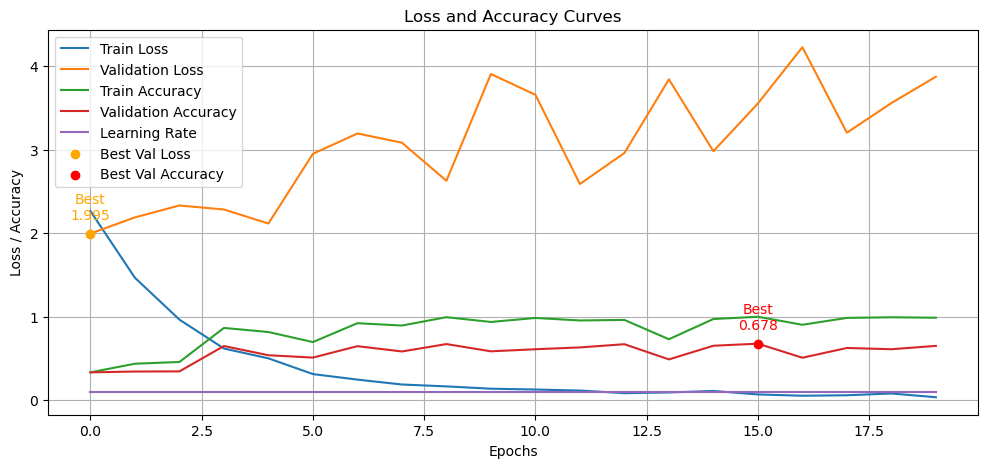

C:\Users\cathalert\AppData\Local\Temp\ipykernel_13408\1622080703.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(fr'{save_path}\best_val_

Train_loss=1.883; Train_accuracy=0.335 
 Validation_loss=1.995; Validation_accuracy=0.335 
Test_loss=1.886; Test_accuracy=0.417 



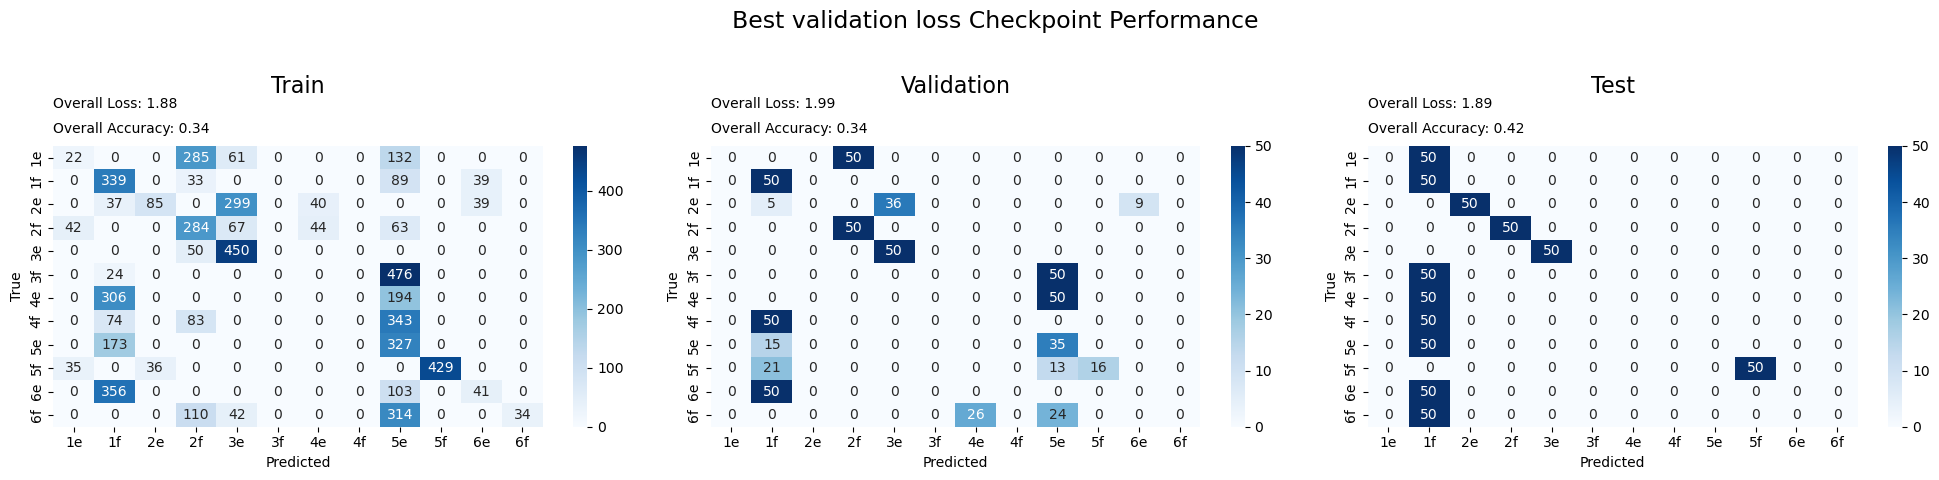

C:\Users\cathalert\AppData\Local\Temp\ipykernel_13408\1622080703.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(fr'{save_path}\best_val_

Train_loss=0.013; Train_accuracy=1.0 
 Validation_loss=3.55; Validation_accuracy=0.678 
Test_loss=15.139; Test_accuracy=0.292 



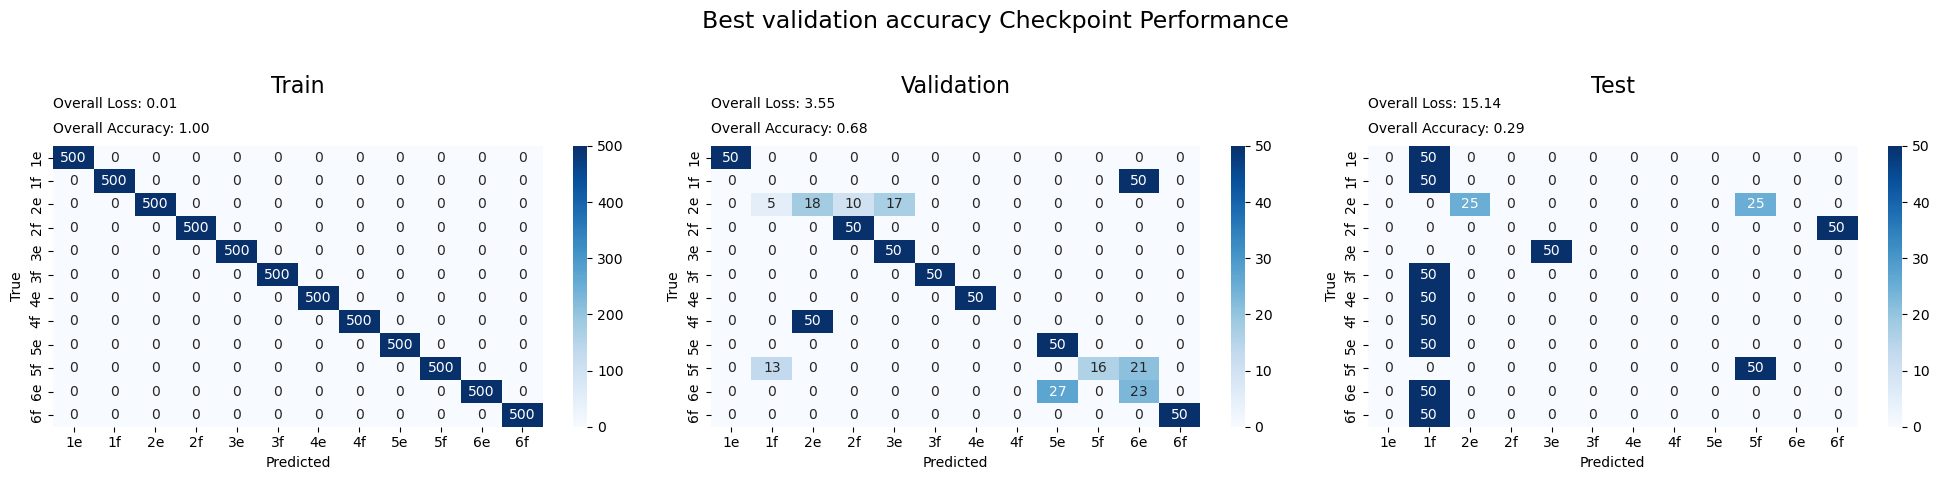

In [85]:

# Plot the loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.plot(train_loss_vec, label='Train Loss')
plt.plot(val_loss_vec, label='Validation Loss')
plt.plot(train_accuracy_vec, label='Train Accuracy')
plt.plot(val_accuracy_vec, label='Validation Accuracy')
plt.plot([l*1000 for l in lr_vec], label='Learning Rate')

# Mark the best validation loss point
if len(val_loss_vec) > 0:
    best_epoch = np.argmin(val_loss_vec)
    plt.scatter(best_epoch, val_loss_vec[best_epoch], color='orange', zorder=5, label='Best Val Loss')
    plt.annotate(f'Best\n{val_loss_vec[best_epoch]:.3f}', 
                 (best_epoch, val_loss_vec[best_epoch]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='orange')
# Mark the best validation accuracy point
if len(val_accuracy_vec) > 0:
    best_epoch = np.argmax(val_accuracy_vec)
    plt.scatter(best_epoch, val_accuracy_vec[best_epoch], color='red', zorder=5, label='Best Val Accuracy')
    plt.annotate(f'Best\n{val_accuracy_vec[best_epoch]:.3f}', 
                 (best_epoch, val_accuracy_vec[best_epoch]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.title('Loss and Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.grid()
plt.show()

labels = ['1e', '1f', '2e', '2f', '3e', '3f', '4e', '4f', '5e', '5f', '6e', '6f']

# # load the last checkpoint
# net.load_state_dict(torch.load(fr'{save_path}\last_cp_e{i_epoch+1}.pth'))
# net.eval()
# evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels , title='Last checkpoint Performance')
# # check the best validation loss

# load the loss best model
net.load_state_dict(torch.load(fr'{save_path}\best_val_loss_cp.pth'))
net.eval()
# evaluate on the test set
evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels , title='Best validation loss Checkpoint Performance')

# load the acc best model
net.load_state_dict(torch.load(fr'{save_path}\best_val_accuracy_cp.pth'))
net.eval()
# evaluate on the test set
evaluate_on_all_sets(net, loss_function, optimizer, dl_train, dl_val, dl_test, device, labels , title='Best validation accuracy Checkpoint Performance')
